In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Jyn', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 17071.19 seconds 
duration: 4.74 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 99.6 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,868.6164,870.5252,,1.9088
1,1160.7812,1162.3060,,1.5248
2,1432.6556,1435.6524,,2.9968
3,1711.6276,1713.4468,,1.8192
4,1971.3252,1973.2732,,1.9480
5,1999.4724,2001.4396,,1.9672
6,2261.4612,2263.0396,,1.5784
7,2633.6172,2634.3116,,0.6944
8,7090.5876,7101.8196,,11.2320
9,7259.7500,7273.5724,,13.8224


<Axes: >

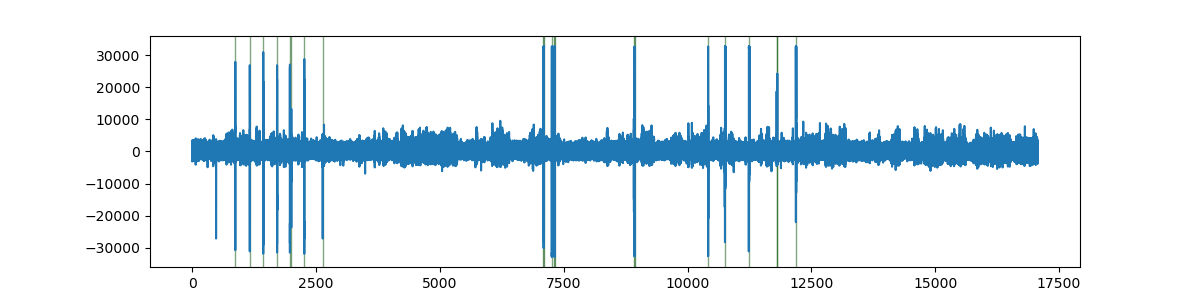

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.probegroup.npy saved


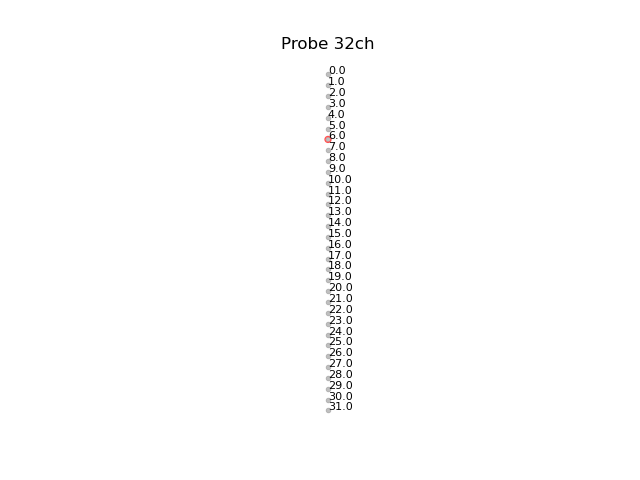

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 18

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [18]
831 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.theta_epochs.npy saved


## Detect SWR Epochs

In [9]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 18
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [18]
8918 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.ripple_epochs.npy saved


In [10]:
# Convert ripple epochs to binned ripple rate
t, rip_bool = ripple_epochs.to_point_process()
from neuropy.core.neurons import BinnedSpiketrain, Neurons
rips = Neurons(t[None, rip_bool], t_stop=50*60)

In [11]:
bin_size_sec = 10
binned_rips = rips.get_binned_spiketrains(bin_size=bin_size_sec)

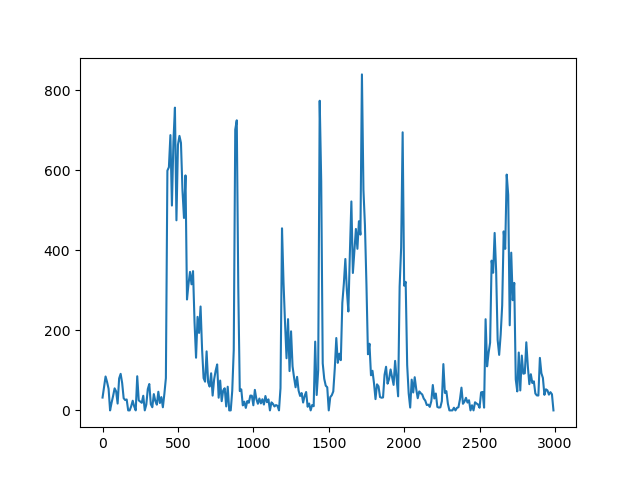

In [12]:
_, ax = plt.subplots()
ax.plot(binned_rips.time, binned_rips.firing_rate[0])

## Delta

In [13]:
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 18

freq_band = (0.5, 4)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal

delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)
sess.recinfo.write_epochs(delta_epochs, ext='dta')
delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
delta_epochs.save(delta_epochs_file)

1241 delta waves detected
/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.delta_epochs.npy saved


In [14]:
#Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 18
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(beta_epochs, ext='bta')
beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs.save(beta_epochs_file)

Best channel for beta: [18]
616 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.beta_epochs.npy saved


In [15]:
#Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 0.5 
highthresh = 5
minDistance = 200
minDuration = 100
gamma_channel = 18

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
sess.recinfo.write_epochs(gamma_epochs, ext='gma')
gamma_epochs_file = sess.filePrefix.with_suffix(".gamma_epochs.npy")
gamma_epochs.save(gamma_epochs_file)

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.gamma_epochs.npy saved


# Wavelet Analysis

### Start with Theta

In [16]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

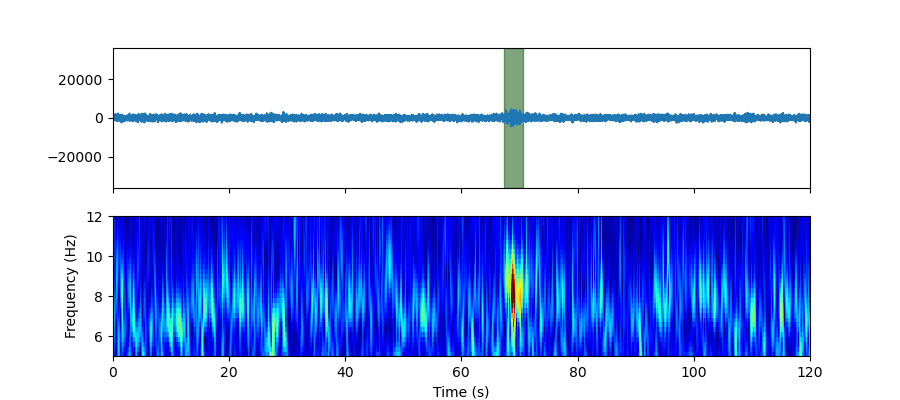

In [17]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

Events [245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

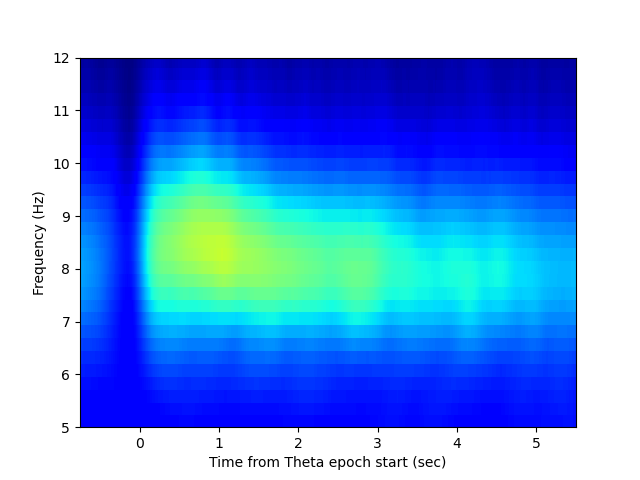

In [18]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [19]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

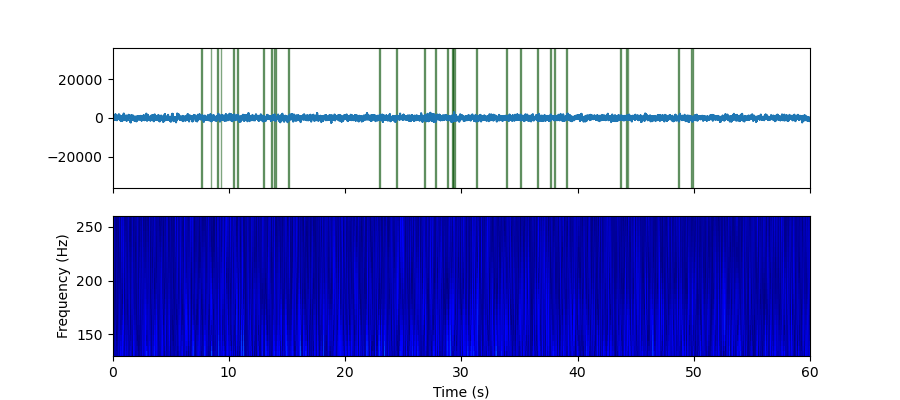

In [20]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

Events [4276 4277 4278 ... 8915 8916 8917] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

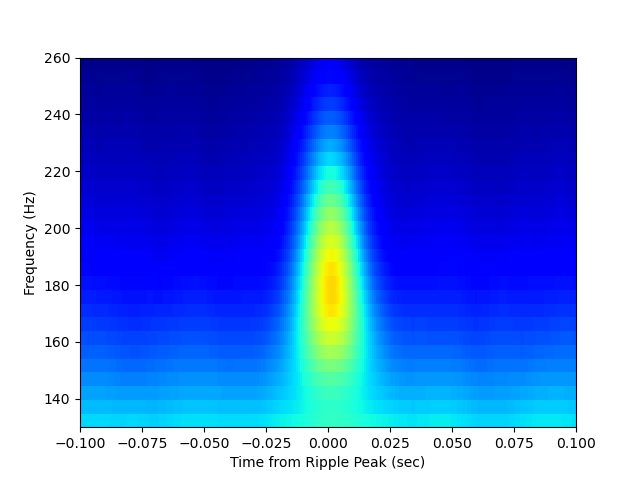

In [21]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Delta

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

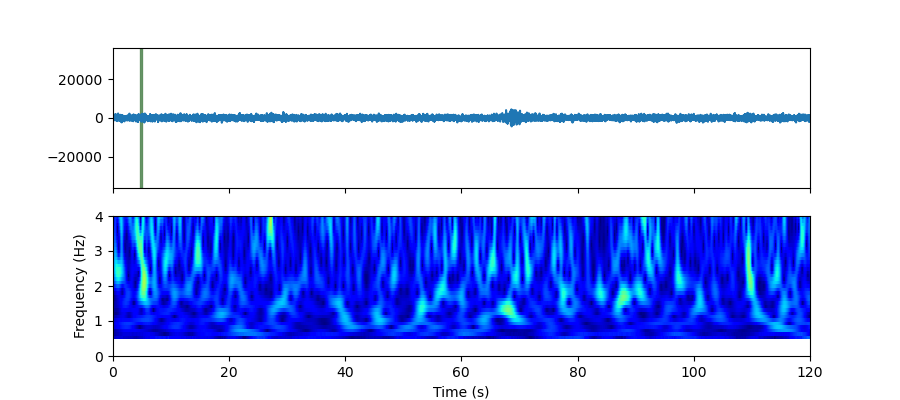

In [22]:
delta_range = np.arange(0.5, 4.25, 0.1)
wv_delta = WaveletSg(signal.time_slice(channel_id=delta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=delta_range, sigma=None)
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
delta_freq_lims = [0.5, 4]

plot_signal_w_epochs(signal, delta_channel, delta_epochs, ax=ax[0])

plot_spectrogram(wv_delta, time_lims=time_to_plot, freq_lims=delta_freq_lims, ax=ax[1])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

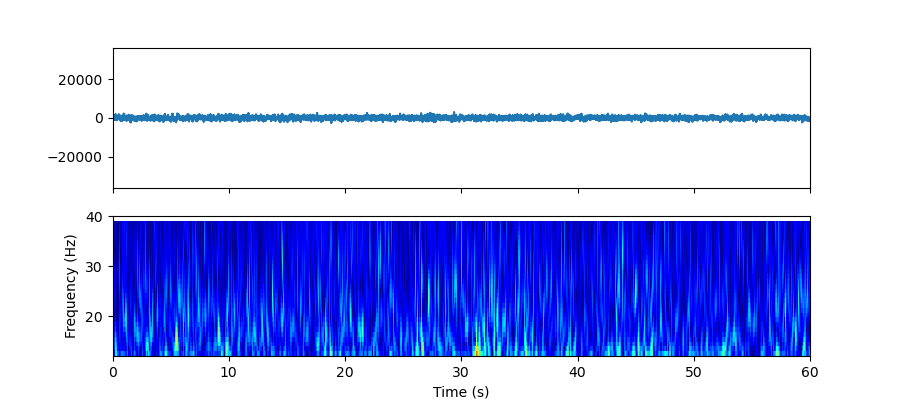

In [23]:
## Beta
beta_range = np.arange(12, 40, 1)  # How do I select these? 
wv_beta = WaveletSg(signal.time_slice(channel_id=beta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=beta_range, sigma=None)

_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
beta_freq_lims = [12, 40]

plot_signal_w_epochs(signal, beta_channel, beta_epochs, ax=ax[0])

plot_spectrogram(wv_beta, time_lims=time_to_plot, freq_lims=beta_freq_lims, ax=ax[1])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

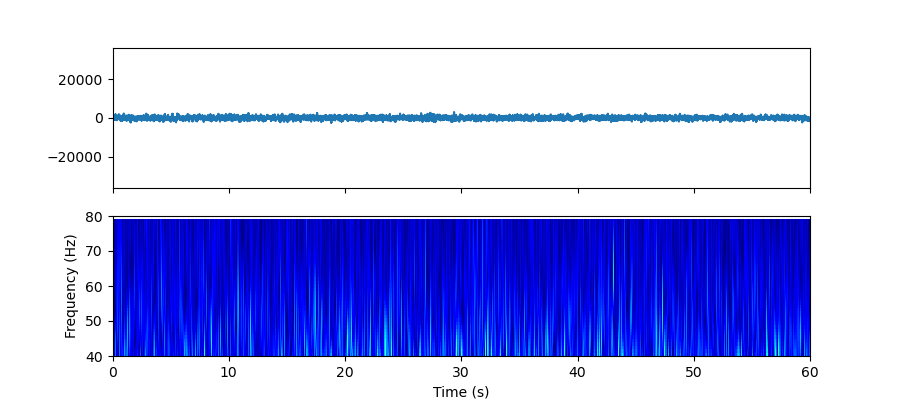

In [24]:
#Gamma
gamma_range = np.arange(40, 80, 1)
wv_gamma = WaveletSg(signal.time_slice(channel_id=gamma_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=gamma_range, sigma=None)

_, ax = plt.subplots(2,1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
gamma_freq_lims = [40, 80]

plot_signal_w_epochs(signal, gamma_channel, gamma_epochs, ax=ax[0])

plot_spectrogram(wv_gamma, time_lims=time_to_plot, freq_lims=gamma_freq_lims, ax=ax[1])

## Peri-USV analyses

In [25]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs

16 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  870.126212  870.171338  505.926529  47.944444  0.045134   27.777778    1.0   
1  871.160586  871.233890  506.961084  45.345779  0.073317   25.343152    1.0   
2  871.556279  871.597182  507.356846  50.209416  0.040911    5.905844    1.0   
3  871.961179  872.056770  507.761818  46.842283  0.095608    5.095238    1.0   
4  872.405570  872.475605  508.206287  45.924784  0.070048    5.326840    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

In [26]:
usv_epochs._epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,870.126212,870.171338,505.926529,47.944444,0.045134,27.777778,1.000000,1,
1,871.160586,871.233890,506.961084,45.345779,0.073317,25.343152,1.000000,1,
2,871.556279,871.597182,507.356846,50.209416,0.040911,5.905844,1.000000,1,
3,871.961179,872.056770,507.761818,46.842283,0.095608,5.095238,1.000000,1,
4,872.405570,872.475605,508.206287,45.924784,0.070048,5.326840,1.000000,1,
5,872.623204,872.696609,508.423960,42.557651,0.073417,27.213203,1.000000,1,
6,873.303583,873.349983,509.104458,38.860931,0.046408,29.645022,1.000000,1,
7,873.580485,873.676931,509.381408,42.366841,0.096464,7.597611,0.544231,1,
8,873.851948,873.887906,509.652919,37.355519,0.035965,29.521707,1.000000,1,
9,874.088381,874.238507,509.889394,43.608766,0.150152,8.221861,0.544231,1,


In [27]:
usv_epochs._epochs.Duration.mean()

0.07507296337757197

In [28]:
short_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Duration<0.1]
short_usv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,870.126212,870.171338,505.926529,47.944444,0.045134,27.777778,1.000000,1,
1,871.160586,871.233890,506.961084,45.345779,0.073317,25.343152,1.000000,1,
2,871.556279,871.597182,507.356846,50.209416,0.040911,5.905844,1.000000,1,
3,871.961179,872.056770,507.761818,46.842283,0.095608,5.095238,1.000000,1,
4,872.405570,872.475605,508.206287,45.924784,0.070048,5.326840,1.000000,1,
5,872.623204,872.696609,508.423960,42.557651,0.073417,27.213203,1.000000,1,
6,873.303583,873.349983,509.104458,38.860931,0.046408,29.645022,1.000000,1,
7,873.580485,873.676931,509.381408,42.366841,0.096464,7.597611,0.544231,1,
8,873.851948,873.887906,509.652919,37.355519,0.035965,29.521707,1.000000,1,
10,874.740853,874.810992,510.541979,38.875000,0.070152,14.461039,0.544231,1,


In [29]:
long_usv_epochs_filtered = usv_epochs._epochs[(usv_epochs._epochs.Duration>0.1)]
long_usv_epochs_filtered

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
9,874.088381,874.238507,509.889394,43.608766,0.150152,8.221861,0.544231,1,
14,879.364718,879.534670,515.166656,41.770022,0.169982,9.365801,0.544231,1,


## Theta mean spectrogram

2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2092 frames between 868.9 and 870.5 ignored (sent to nan)
1796 frames between 869.1 and 870.5 ignored (sent to nan)
981 frames between 869.7 and 870.5 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start(sec)')

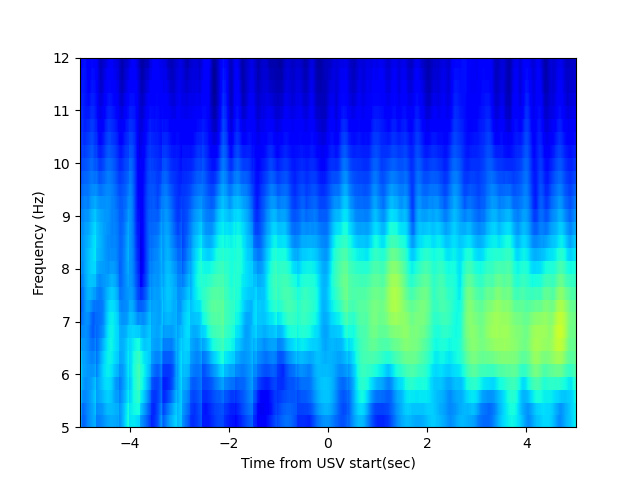

In [30]:
# Example code to plot theta at USV starts
usv_buffer_sec = (5, 5)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

2385 frames between 868.6 and 870.5 ignored (sent to nan)
1614 frames between 869.2 and 870.5 ignored (sent to nan)
1160 frames between 869.6 and 870.5 ignored (sent to nan)
586 frames between 870.1 and 870.5 ignored (sent to nan)
62 frames between 870.5 and 870.5 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV stop(sec)')

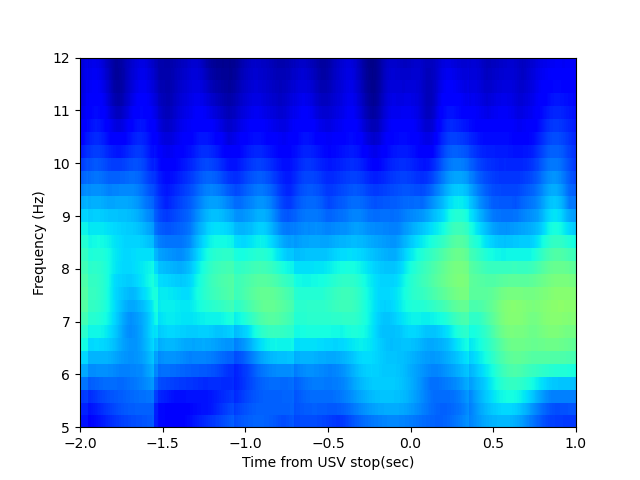

In [31]:
usv_buffer_sec = (2, 1)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['stop'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV stop(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start (sec)')

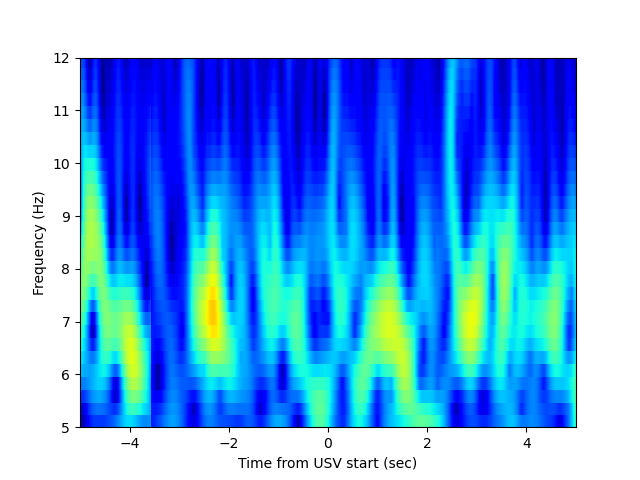

In [32]:
# Example code to plot theta at USV starts
usv_buffer_sec = (5, 5)
wv_theta_mean = wv_theta.get_pe_mean_spec(long_usv_epochs_filtered['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
1727 frames between 869.1 and 870.5 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start (sec)')

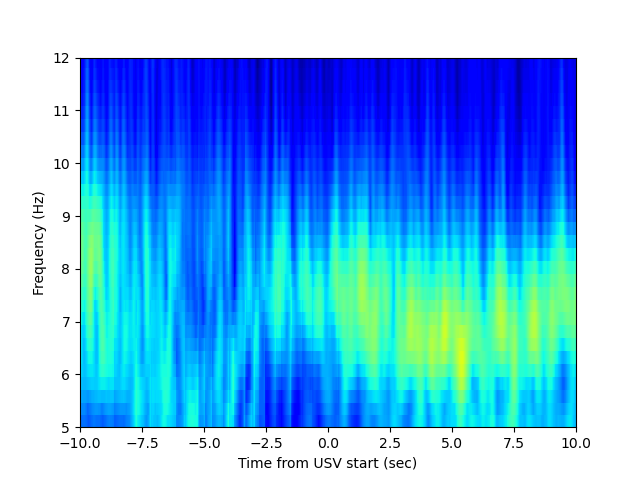

In [33]:
# Example code to plot theta at USV starts
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

## Ripple mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

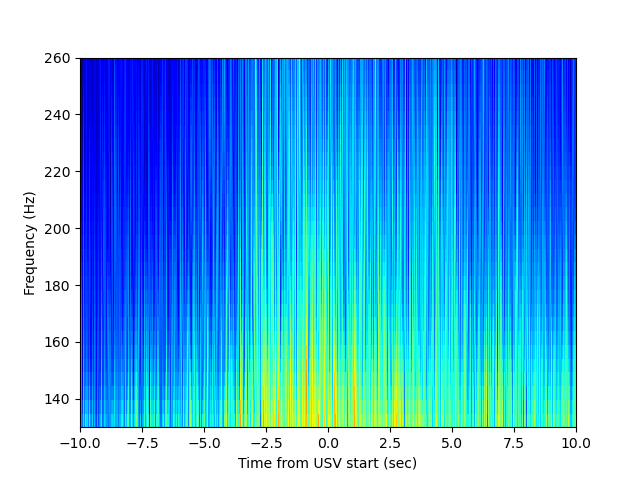

In [34]:
# All
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

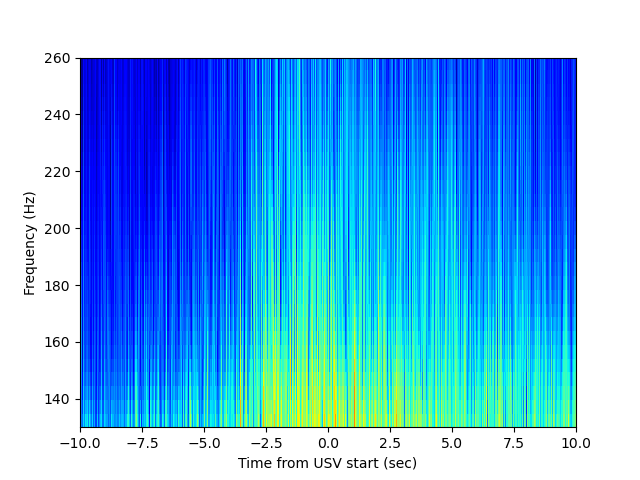

In [35]:
# short USV
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

1796 frames between 869.1 and 870.5 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

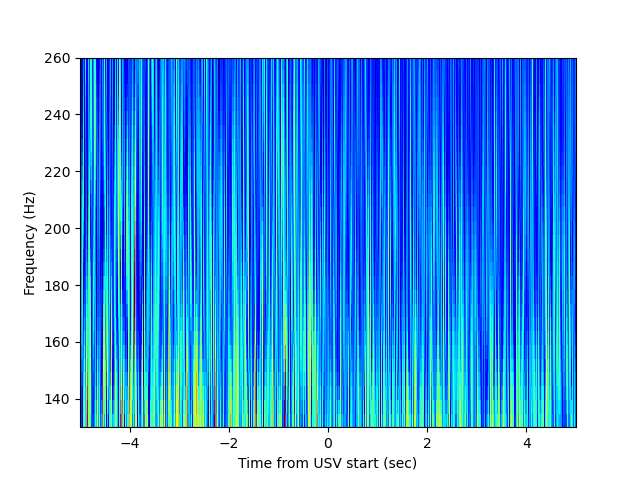

In [36]:
#long USV
usv_buffer_sec = (5,5)
wv_swr_mean = wv_swr.get_pe_mean_spec(long_usv_epochs_filtered['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

Text(0.5, 0, 'Time from USV start(sec)')

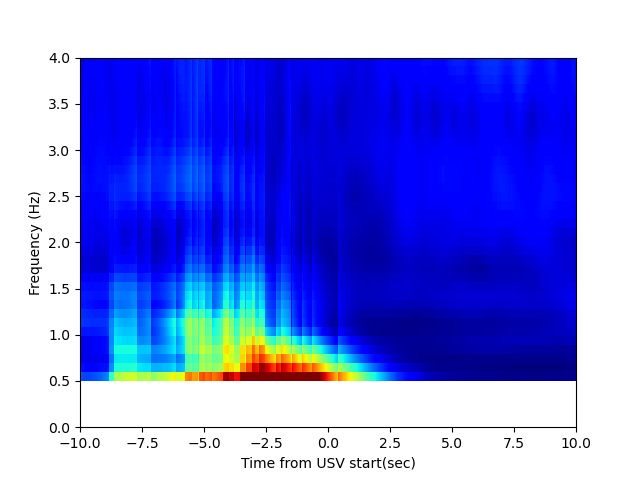

In [37]:
# Delta
#Delta
usv_buffer_sec = (10, 10)
wv_delta_mean = wv_delta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_delta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=delta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start(sec)')

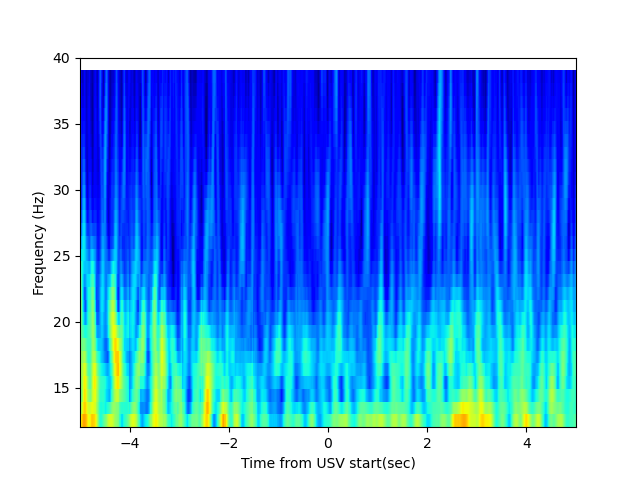

In [38]:
#Beta
usv_buffer_sec = (5, 5)
wv_beta_mean = wv_beta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2386 frames between 868.6 and 870.5 ignored (sent to nan)
2092 frames between 868.9 and 870.5 ignored (sent to nan)
1796 frames between 869.1 and 870.5 ignored (sent to nan)
981 frames between 869.7 and 870.5 ignored (sent to nan)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start(sec)')

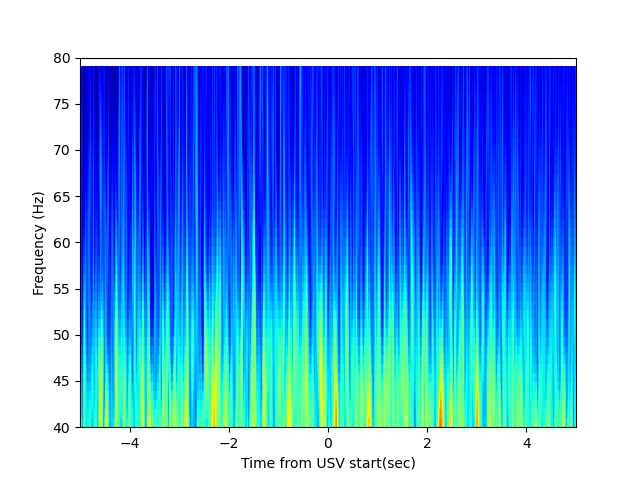

In [39]:
#Gamma
usv_buffer_sec = (5, 5)
wv_gamma_mean = wv_gamma.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=True)
ax = plot_spectrogram(wv_gamma_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=gamma_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

## Finn recall7 note:
pyr channel (26) has weird-looking oscillations particularly during CS- and CS+(2) times.  I have used channel 20 instead which is well above the cell layer but has good-looking volume-conducted theta.  SWR detection appears to be fine using ch 26.

## Save notebook to working directory

In [40]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Animal_files/USV_Spectral_Analysis(Jyn).ipynb saved to /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_USV_Spectral_Analysis(Jyn).ipynb


In [41]:
pip install jupyter-save-load-vars

Note: you may need to restart the kernel to use updated packages.
